In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
# from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,Dropout
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
IMG_SHAPE = (350,350)
IMG_SHAPE_GN = (350,350,3)

In [3]:
# Process image (input) for the model
def process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SHAPE)
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

# Read image
def get_image(path):
    image = cv2.imread(path)
    if image is None or image.size == 0:
        print(f"Error loading image from path: {path}")
        return None

    try:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    except Exception as e:
        print(f"Error converting image from path {path}: {e}")
        return None
    
# Visualize samples
def visualize_samples(datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    filepaths = "D:/periodontitis/archive/" + filepaths
    images = filepaths.apply(get_image).reset_index(drop=True)
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            if images[sample_index] is not None:  # Skip over images that failed to load
                ax[i,j].imshow(images[sample_index])
                ax[i,j].set_title(labels[sample_index])
                ax[i,j].set_axis_off()
    plt.show()
    
    
# Make classifications & visualize results
def visualize_classifications(model, datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    filepaths = "D:/periodontitis/archive" + filepaths
#     print(filepaths[0])
    images = filepaths.apply(get_image).reset_index(drop=True)
    processed_images = np.vstack(images.apply(process).to_numpy()[:])
    
    y_pred = classes[np.argmax(model.predict(processed_images, verbose=0), axis=1)]
    y_pred = pd.Series(y_pred).replace({"penyakit-non-periodontal":"NOT Periodontal", "penyakit-periodontal":"Periodontal"}).to_numpy()
    y_true = labels
    y_true = pd.Series(labels).replace({"penyakit-non-periodontal":"NOT Periodontal", "penyakit-periodontal":"Periodontal"}).to_numpy()
    
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            is_correct_answer = "correct" if y_pred[sample_index] == y_true[sample_index] else "wrong"
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(f"({y_pred[sample_index]}) [{is_correct_answer}]")
            ax[i,j].set_axis_off()
    plt.show()
    
def sched(epoch, lr):
    return lr * tf.math.exp(-0.1)

In [4]:
train_datagen = ImageDataGenerator(    
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2,
  )


validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
)

In [5]:
train_gen_flow = train_datagen.flow_from_directory(
        directory="D:/periodontitis/archive",
        target_size=IMG_SHAPE,
        batch_size=64,
        class_mode="binary",
        subset='training'
)

valid_gen_flow = validation_datagen.flow_from_directory(
        directory="D:/periodontitis/archive",
        target_size=IMG_SHAPE,
        batch_size=64,
        class_mode="binary",
        subset='validation')

Found 809 images belonging to 4 classes.
Found 202 images belonging to 4 classes.


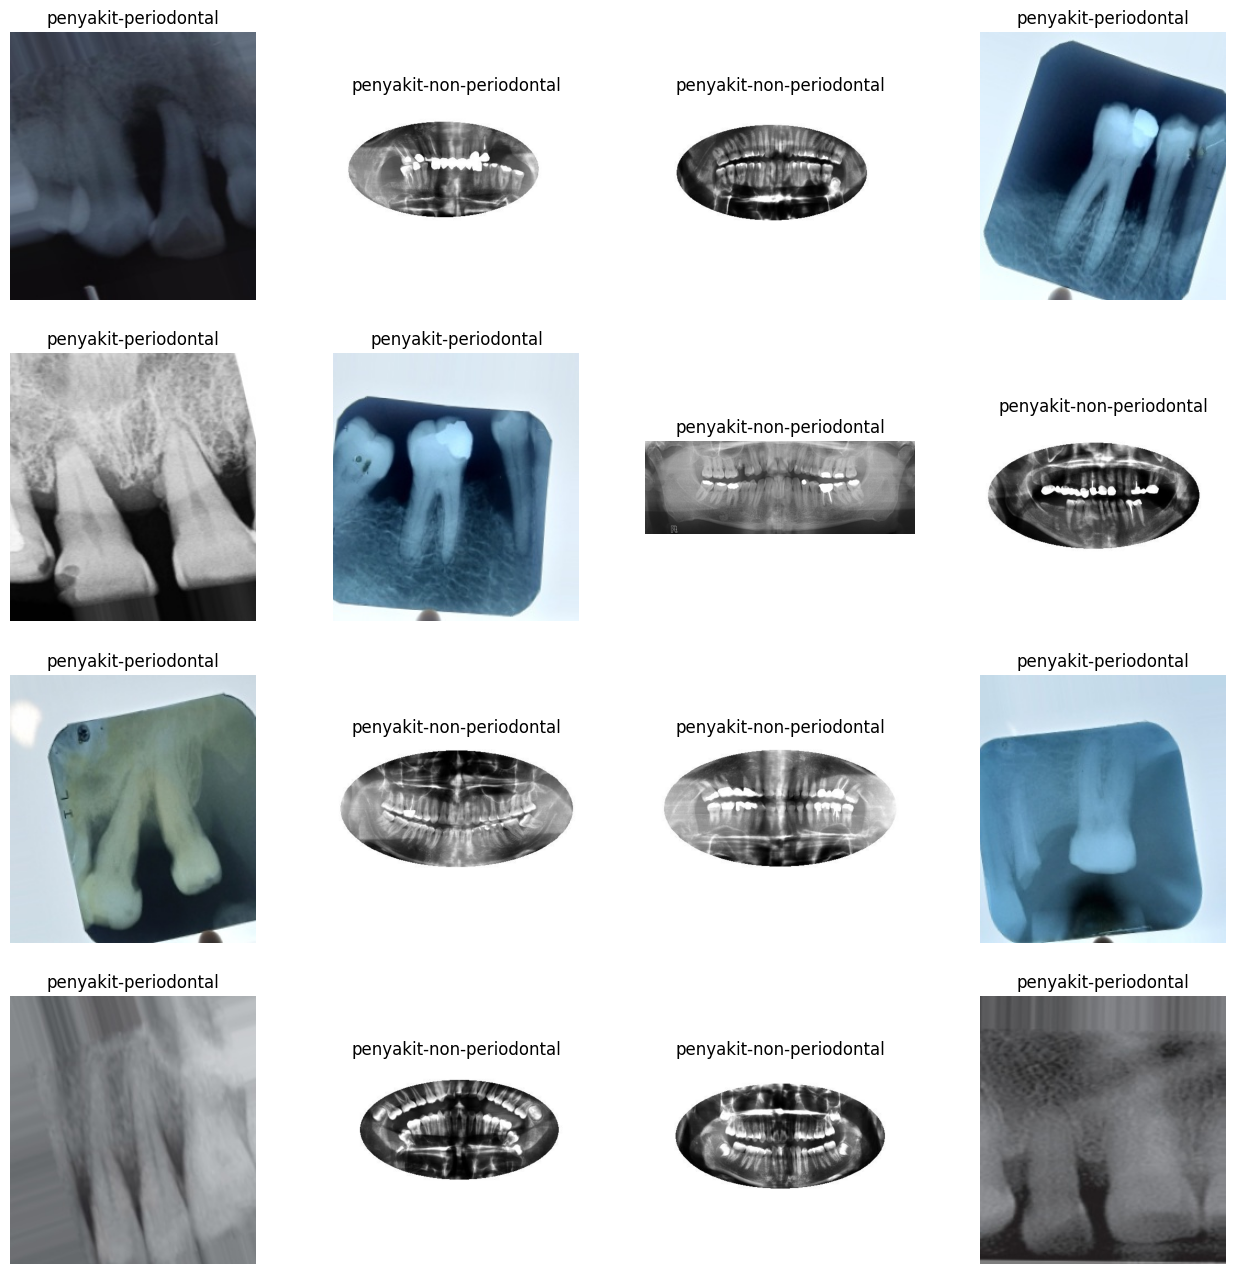

In [6]:
visualize_samples(train_gen_flow)

In [7]:
import tensorflow as tf

# Define MobileNetV2 with pre-trained weights
pretrainedModel = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE_GN,
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrainedModel.trainable = False

# Add dropout and additional layers
x = tf.keras.layers.Dense(256, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dropout(0.7)(x)  # Increase dropout rate
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.7)(x)  # Increase dropout rate
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.7)(x)  # Increase dropout rate

# Output layer
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Define the model
model = tf.keras.Model(inputs=pretrainedModel.input, outputs=outputs)

# Compile the model with appropriate loss and metrics
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.Recall()])

# Define more aggressive data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,  # Increase rotation range
    width_shift_range=0.3,  # Increase width shift range
    height_shift_range=0.3,  # Increase height shift range
    shear_range=0.3,  # Increase shear range
    zoom_range=0.3,  # Increase zoom range
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=True,  # Flip images vertically
    rescale=1./255  # Rescale pixel values
)



In [21]:
history = model.fit(
    train_gen_flow,
    validation_data=valid_gen_flow,
    verbose=1,
    epochs=3,
    callbacks=[tf.keras.callbacks.LearningRateScheduler(sched)]
)


Epoch 1/3
13/13 [==============================] - 91s 7s/step - loss: -4.5195 - accuracy: 0.4351 - recall: 0.8591 - val_loss: -14.0212 - val_accuracy: 0.4950 - val_recall: 1.0000 - lr: 9.0484e-04
Epoch 2/3
13/13 [==============================] - 52s 4s/step - loss: -39.5816 - accuracy: 0.4907 - recall: 0.9901 - val_loss: -77.8421 - val_accuracy: 0.4950 - val_recall: 1.0000 - lr: 8.1873e-04
Epoch 3/3
13/13 [==============================] - 60s 5s/step - loss: -157.1516 - accuracy: 0.4944 - recall: 0.9988 - val_loss: -296.2726 - val_accuracy: 0.4950 - val_recall: 1.0000 - lr: 7.4082e-04


In [22]:
print("Model Evaluation")
score = model.evaluate(valid_gen_flow)

Model Evaluation
4/4 [==============================] - 7s 2s/step - loss: -296.2726 - accuracy: 0.4950 - recall: 1.0000


In [23]:
model.save("PeriodontalClassifierNet.h5")

C:\Users\arthi\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
def classify_new_image(model_path, image_path):
    model = tf.keras.models.load_model(model_path)

    image = get_image(image_path)
    if image is None:
        return "Image could not be loaded or processed."

    processed_image = process(image)

    prediction = model.predict(processed_image)
    predicted_class = "Periodontal" if prediction[0] > 0.5 else "NOT Periodontal"

    return predicted_class

image_path = "D:/periodontitis/archive/test/non_periodontal_9.png"
model_path = "PeriodontalClassifierNet.h5"
result = classify_new_image(model_path, image_path)
print(f"The image was classified as: {result}")

1/1 [==============================] - 1s 645ms/step
The image was classified as: Periodontal


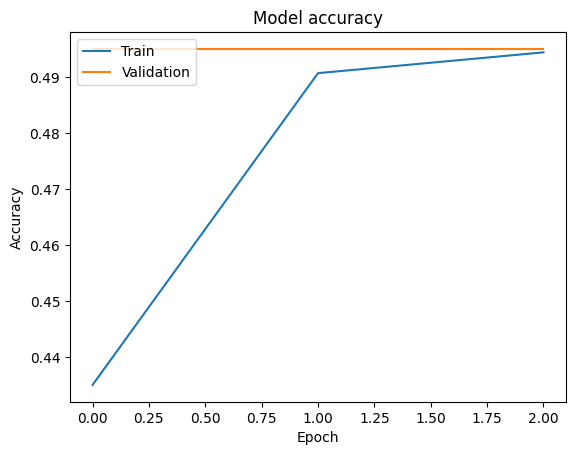

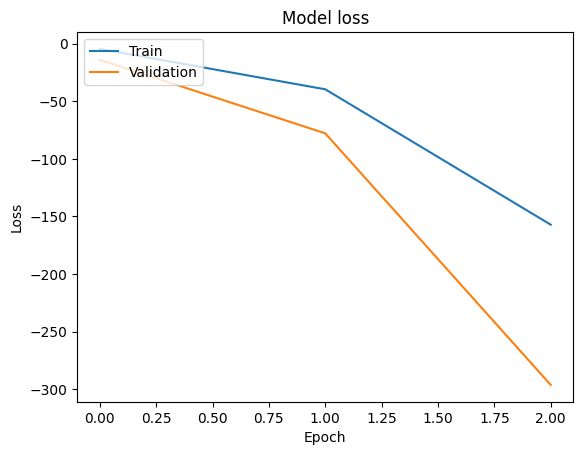

In [25]:
import matplotlib.pyplot as plt

def plot_train_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Assuming you have `history` object from model.fit()
plot_train_history(history)
